# Tutorial on Machine Learning with MLJ

In [21]:
using Pkg
Pkg.activate()

  Activating project at `~/.julia/environments/v1.7`


In [78]:
using MLJ
using VegaLite
ENV["COLUMNS"] = 10_000;

## 1. O Básico

In [3]:
const X_iris, y_iris = @load_iris;
schema(X_iris)

┌──────────────┬────────────┬─────────┐
│ names        │ scitypes   │ types   │
├──────────────┼────────────┼─────────┤
│ sepal_length │ Continuous │ Float64 │
│ sepal_width  │ Continuous │ Float64 │
│ petal_length │ Continuous │ Float64 │
│ petal_width  │ Continuous │ Float64 │
└──────────────┴────────────┴─────────┘


In [4]:
levels(y_iris)

3-element Vector{String}:
 "setosa"
 "versicolor"
 "virginica"

In [5]:
DecisionTree = @load DecisionTreeClassifier pkg=BetaML # model type

import BetaML ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/davibarreira/.julia/packages/MLJModels/lDzCR/src/loading.jl:168


BetaML.Trees.DecisionTreeClassifier

In [6]:
model = DecisionTree(minRecords=5)                    # model instance

DecisionTreeClassifier(
  maxDepth = 0, 
  minGain = 0.0, 
  minRecords = 5, 
  maxFeatures = 0, 
  splittingCriterion = BetaML.Utils.gini, 
  rng = Random._GLOBAL_RNG())

In [7]:
mach = machine(model, X_iris, y_iris)

Machine trained 0 times; caches data
  model: DecisionTreeClassifier(maxDepth = 0, …)
  args: 
    1:	Source @016 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @711 ⏎ `AbstractVector{Multiclass{3}}`


In [8]:
train_rows = vcat(1:60, 91:150); # some row indices (observations are rows not columns)
fit!(mach, rows=train_rows)
fitted_params(mach)

┌ Info: Training machine(DecisionTreeClassifier(maxDepth = 0, …), …).
└ @ MLJBase /home/davibarreira/.julia/packages/MLJBase/jcOVb/src/machines.jl:487


(fitresult = (BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(4, 1.0), BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(3, 4.8), BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(4, 1.6), BetaML.Trees.Leaf{String}(Dict("virginica" => 1.0), 4), BetaML.Trees.Leaf{String}(Dict("virginica" => 0.75, "versicolor" => 0.25), 4), 3, 0.92), BetaML.Trees.DecisionNode{Float64}(BetaML.Trees.Question{Float64}(4, 1.7), BetaML.Trees.Leaf{String}(Dict("virginica" => 1.0), 4), BetaML.Trees.Leaf{String}(Dict("versicolor" => 1.0), 4), 3, 0.05), 2, 0.7142857142857143), BetaML.Trees.Leaf{String}(Dict("setosa" => 1.0), 2), 1, 0.5833333333333334), CategoricalArrays.CategoricalValue{String, UInt32} "setosa"),)

In [9]:
predict(mach, rows=71:73)

3-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(setosa=>0.0, versicolor=>0.0, virginica=>1.0)
 UnivariateFinite{Multiclass{3}}(setosa=>0.0, versicolor=>1.0, virginica=>0.0)
 UnivariateFinite{Multiclass{3}}(setosa=>0.0, versicolor=>0.25, virginica=>0.75)

In [10]:
Xnew = (sepal_length = [5.1, 6.3],
        sepal_width = [3.0, 2.5],
        petal_length = [1.4, 4.9],
        petal_width = [0.3, 1.5])
yhat = predict(mach, Xnew)

2-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(setosa=>1.0, versicolor=>0.0, virginica=>0.0)
 UnivariateFinite{Multiclass{3}}(setosa=>0.0, versicolor=>0.25, virginica=>0.75)

In [11]:
pdf.(yhat, "virginica")

2-element Vector{Float64}:
 0.0
 0.75

## 2. Indo mais a fundo

In [12]:
using DataFrames
data = OpenML.load(42178) # data set from OpenML.org
df0 = DataFrame(data)
first(df0, 4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines
,String,String,Float64,String,String,Float64,String,String
1,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No phone service
2,5575-GNVDE,Male,0.0,No,No,34.0,Yes,No
3,3668-QPYBK,Male,0.0,No,No,2.0,Yes,No
4,7795-CFOCW,Male,0.0,No,No,45.0,No,No phone service


In [13]:
fix_blanks(v) = map(v) do x
    if x == " "
        return "0.0"
    else
        return x
    end
end

df0.TotalCharges = fix_blanks(df0.TotalCharges);

In [14]:
coerce!(df0, :TotalCharges => Continuous);
coerce!(df0, Textual => Multiclass);
coerce!(df0, :Churn => OrderedFactor)
levels(df0.Churn) # to check order

2-element Vector{String}:
 "No"
 "Yes"

In [15]:
schema(df0) |> DataFrames.DataFrame

,names,scitypes,types
,Symbol,DataType,DataType
1,customerID,Multiclass{7043},"CategoricalValue{String, UInt32}"
2,gender,Multiclass{2},"CategoricalValue{String, UInt32}"
3,SeniorCitizen,Continuous,Float64
4,Partner,Multiclass{2},"CategoricalValue{String, UInt32}"
5,Dependents,Multiclass{2},"CategoricalValue{String, UInt32}"
6,tenure,Continuous,Float64
7,PhoneService,Multiclass{2},"CategoricalValue{String, UInt32}"
8,MultipleLines,Multiclass{3},"CategoricalValue{String, UInt32}"
9,InternetService,Multiclass{3},"CategoricalValue{String, UInt32}"


In [16]:
df, df_test, df_dumped = partition(df0, 0.07, 0.03, # in ratios 7:3:90
                                   stratify=df0.Churn,
                                   rng=123);

In [17]:
const y, X = unpack(df, ==(:Churn), !=(:customerID));
const ytest, Xtest = unpack(df_test, ==(:Churn), !=(:customerID));

In [25]:
Booster = @load EvoTreeClassifier pkg=EvoTrees

import EvoTrees ✔


┌ Info: Precompiling EvoTrees [f6006082-12f8-11e9-0c9c-0d5d367ab1e5]
└ @ Base loading.jl:1423
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/davibarreira/.julia/packages/MLJModels/lDzCR/src/loading.jl:168


EvoTreeClassifier

In [26]:
booster = Booster()

EvoTreeClassifier(
  loss = EvoTrees.Softmax(), 
  nrounds = 10, 
  λ = 0.0, 
  γ = 0.0, 
  η = 0.1, 
  max_depth = 5, 
  min_weight = 1.0, 
  rowsample = 1.0, 
  colsample = 1.0, 
  nbins = 64, 
  α = 0.5, 
  metric = :mlogloss, 
  rng = Random.MersenneTwister(123), 
  device = "cpu")

Nosso modelo não pode ser utilizado diretamente.

In [28]:
scitype(X) <: input_scitype(booster)

false

In [29]:
pipe = ContinuousEncoder() |> booster

ProbabilisticPipeline(
  continuous_encoder = ContinuousEncoder(
        drop_last = false, 
        one_hot_ordered_factors = false), 
  evo_tree_classifier = EvoTreeClassifier(
        loss = EvoTrees.Softmax(), 
        nrounds = 10, 
        λ = 0.0, 
        γ = 0.0, 
        η = 0.1, 
        max_depth = 5, 
        min_weight = 1.0, 
        rowsample = 1.0, 
        colsample = 1.0, 
        nbins = 64, 
        α = 0.5, 
        metric = :mlogloss, 
        rng = Random.MersenneTwister(123), 
        device = "cpu"), 
  cache = true)

In [31]:
pipe.evo_tree_classifier.max_depth

5

In [32]:
mach_pipe = machine(pipe, X, y)

Machine trained 0 times; caches data
  model: ProbabilisticPipeline(continuous_encoder = ContinuousEncoder(drop_last = false, …), …)
  args: 
    1:	Source @851 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{Multiclass{2}}, AbstractVector{Multiclass{4}}}}`
    2:	Source @689 ⏎ `AbstractVector{OrderedFactor{2}}`


In [33]:
train, validation = partition(1:length(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  336, 337, 338, 339, 340, 341, 342, 343, 344, 345], [346, 347, 348, 349, 350, 351, 352, 353, 354, 355  …  484, 485, 486, 487, 488, 489, 490, 491, 492, 493])

In [34]:
fit!(mach_pipe, rows=train)

┌ Info: Training machine(ProbabilisticPipeline(continuous_encoder = ContinuousEncoder(drop_last = false, …), …), …).
└ @ MLJBase /home/davibarreira/.julia/packages/MLJBase/jcOVb/src/machines.jl:487
┌ Info: Training machine(ContinuousEncoder(drop_last = false, …), …).
└ @ MLJBase /home/davibarreira/.julia/packages/MLJBase/jcOVb/src/machines.jl:487
┌ Info: Training machine(EvoTreeClassifier(loss = EvoTrees.Softmax(), …), …).
└ @ MLJBase /home/davibarreira/.julia/packages/MLJBase/jcOVb/src/machines.jl:487


Machine trained 1 time; caches data
  model: ProbabilisticPipeline(continuous_encoder = ContinuousEncoder(drop_last = false, …), …)
  args: 
    1:	Source @851 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{Multiclass{2}}, AbstractVector{Multiclass{4}}}}`
    2:	Source @689 ⏎ `AbstractVector{OrderedFactor{2}}`


In [35]:
fp = fitted_params(mach_pipe);
keys(fp)

(:evo_tree_classifier, :continuous_encoder, :machines, :fitted_params_given_machine)

Aqui vamos checar que de fato temos as mesmas variáveis
no modelo quanto na base, ou seja,
que nosso pipe não jogou nada fora.

In [36]:
Set(fp.continuous_encoder.features_to_keep) == Set(schema(X).names)

true

In [42]:
rpt = report(mach_pipe)
keys(rpt.evo_tree_classifier)

(:feature_importances,)

In [44]:
fi = rpt.evo_tree_classifier.feature_importances
feature_importance_table =
    (feature=Symbol.(first.(fi)), importance=last.(fi)) |> DataFrames.DataFrame

,feature,importance
,Symbol,Float64
1,tenure,0.367021
2,MonthlyCharges,0.167477
3,Contract__Month-to-month,0.16637
4,TotalCharges,0.0608734
5,PaymentMethod__Bank transfer (automatic),0.0381171
6,Dependents__No,0.0273874
7,SeniorCitizen,0.0262011
8,PaperlessBilling__No,0.024691
9,DeviceProtection__No,0.0234396


In [44]:
fi = rpt.evo_tree_classifier.feature_importances
feature_importance_table =
    (feature=Symbol.(first.(fi)), importance=last.(fi)) |> DataFrames.DataFrame

,feature,importance
,Symbol,Float64
1,tenure,0.367021
2,MonthlyCharges,0.167477
3,Contract__Month-to-month,0.16637
4,TotalCharges,0.0608734
5,PaymentMethod__Bank transfer (automatic),0.0381171
6,Dependents__No,0.0273874
7,SeniorCitizen,0.0262011
8,PaperlessBilling__No,0.024691
9,DeviceProtection__No,0.0234396


In [51]:
ŷ = predict(mach_pipe, rows=validation);
@info("Measurements",
      brier_loss(ŷ, y[validation]) |> mean,
      auc(ŷ, y[validation]),
      accuracy(mode.(ŷ), y[validation])
      )

┌ Info: Measurements
│   brier_loss(ŷ, y[validation]) |> mean = 0.27683139589958233
│   auc(ŷ, y[validation]) = 0.8171277997364954
│   accuracy(mode.(ŷ), y[validation]) = 0.7972972972972973
└ @ Main In[51]:2


In [52]:
confmat(mode.(ŷ), y[validation])

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     No      │     Yes     │
├─────────────┼─────────────┼─────────────┤
│     No      │     101     │     16      │
├─────────────┼─────────────┼─────────────┤
│     Yes     │     14      │     17      │
└─────────────┴─────────────┴─────────────┘


In [61]:
fp, tp = roc(ŷ, y[validation]);

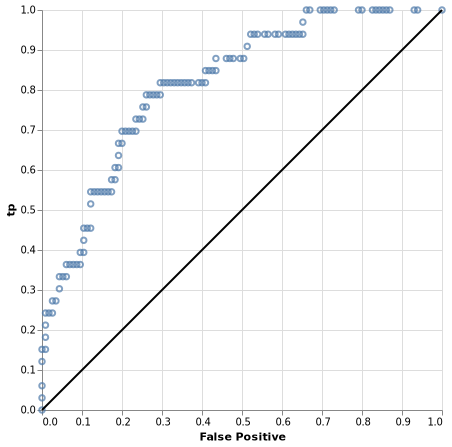

In [75]:
plt = @vlplot(
    data=DataFrame(fp = fp,tp = tp),
    :point,
    x={:fp, title="False Positive",type=:q},
    y={:tp, tiltle="True Positive", type=:q},
    width=400,
    height=400
)
l = @vlplot(
    data= DataFrame(fp=[0,1],tp=[0,1]),
    mark={:line,color="black"},
    x={:fp, title="False Positive",type=:q},
        y={:tp, tiltle="True Positive", type=:q},
    width=400,
    height=400
)

@vlplot() + plt + l

In [79]:
e_pipe = evaluate(pipe, X, y,
                  resampling=StratifiedCV(nfolds=6, rng=123),
                  measures=[brier_loss, auc, accuracy],
                  repeats=3,
                  acceleration=CPUThreads())

┌ Info: Performing evaluations using 4 threads.
└ @ MLJBase /home/davibarreira/.julia/packages/MLJBase/jcOVb/src/resampling.jl:1218
Evaluating over 18 folds: 100%[=========================] Time: 0:00:00


PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌──────────────────┬──────────────┬─────────────┬─────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ measure          │ operation    │ measurement │ 1.96*SE │ per_fold                                                                                                                       │
├──────────────────┼──────────────┼─────────────┼─────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ BrierLoss()      │ predict      │ 0.313       │ 0.0136  │ [0.311, 0.344, 0.291, 0.348, 0.357, 0.295, 0.285, 0.313, 0.324, 0.296, 0.284, 0.343, 0.316, 0.268, 0.306, 0.369, 0.287, 0.298] │
│ AreaUnderCurve() │ predict      │ 0.788       │ 0.0226  │ [0.7

## Filtrando Variáveis por Importância

In [80]:
unimportant_features = filter(:importance => <(0.005), feature_importance_table).feature

29-element Vector{Symbol}:
 :TechSupport__No
 Symbol("PaymentMethod__Credit card (automatic)")
 :StreamingMovies__No
 Symbol("Contract__One year")
 Symbol("Contract__Two year")
 :Partner__Yes
 :OnlineBackup__No
 :Dependents__Yes
 :Partner__No
 :gender__Male
 Symbol("PaymentMethod__Mailed check")
 Symbol("OnlineSecurity__No internet service")
 :OnlineSecurity__No
 ⋮
 Symbol("OnlineBackup__No internet service")
 :InternetService__No
 :StreamingTV__Yes
 :PhoneService__No
 :PhoneService__Yes
 Symbol("DeviceProtection__No internet service")
 Symbol("StreamingTV__No internet service")
 Symbol("StreamingMovies__No internet service")
 Symbol("TechSupport__No internet service")
 :MultipleLines__Yes
 Symbol("MultipleLines__No phone service")
 :InternetService__DSL

In [81]:
pipe2 = ContinuousEncoder() |>
    FeatureSelector(features=unimportant_features, ignore=true) |> booster

ProbabilisticPipeline(
  continuous_encoder = ContinuousEncoder(
        drop_last = false, 
        one_hot_ordered_factors = false), 
  feature_selector = FeatureSelector(
        features = [:TechSupport__No, Symbol("PaymentMethod__Credit card (automatic)"), :StreamingMovies__No, Symbol("Contract__One year"), Symbol("Contract__Two year"), :Partner__Yes, :OnlineBackup__No, :Dependents__Yes, :Partner__No, :gender__Male  …  :StreamingTV__Yes, :PhoneService__No, :PhoneService__Yes, Symbol("DeviceProtection__No internet service"), Symbol("StreamingTV__No internet service"), Symbol("StreamingMovies__No internet service"), Symbol("TechSupport__No internet service"), :MultipleLines__Yes, Symbol("MultipleLines__No phone service"), :InternetService__DSL], 
        ignore = true), 
  evo_tree_classifier = EvoTreeClassifier(
        loss = EvoTrees.Softmax(), 
        nrounds = 10, 
        λ = 0.0, 
        γ = 0.0, 
        η = 0.1, 
        max_depth = 5, 
        min_weight = 1.0, 
        

## Controlando Otimização de Hiperparâmetros

In [82]:
controls = [
    Step(1),              # to increment iteration parameter (`pipe.nrounds`)
    NumberSinceBest(4),   # main stopping criterion
    TimeLimit(2/3600),    # never train more than 2 sec
    InvalidValue()        # stop if NaN or ±Inf encountered
]

4-element Vector{Any}:
 Step(1)
 NumberSinceBest(4)
 TimeLimit(Dates.Millisecond(2000))
 InvalidValue()

In [83]:
iterated_pipe = IteratedModel(model=pipe2,
                              controls=controls,
                              measure=brier_loss,
                              resampling=Holdout(fraction_train=0.7))

ProbabilisticIteratedModel(
  model = ProbabilisticPipeline(
        continuous_encoder = ContinuousEncoder(drop_last = false, …), 
        feature_selector = FeatureSelector(features = [:TechSupport__No, Symbol("PaymentMethod__Credit card (automatic)"), :StreamingMovies__No, Symbol("Contract__One year"), Symbol("Contract__Two year"), :Partner__Yes, :OnlineBackup__No, :Dependents__Yes, :Partner__No, :gender__Male, Symbol("PaymentMethod__Mailed check"), Symbol("OnlineSecurity__No internet service"), :OnlineSecurity__No, Symbol("PaymentMethod__Electronic check"), :OnlineSecurity__Yes, Symbol("InternetService__Fiber optic"), :TechSupport__Yes, Symbol("OnlineBackup__No internet service"), :InternetService__No, :StreamingTV__Yes, :PhoneService__No, :PhoneService__Yes, Symbol("DeviceProtection__No internet service"), Symbol("StreamingTV__No internet service"), Symbol("StreamingMovies__No internet service"), Symbol("TechSupport__No internet service"), :MultipleLines__Yes, Symbol("MultipleLine

In [84]:
mach_iterated_pipe = machine(iterated_pipe, X, y)
fit!(mach_iterated_pipe);

┌ Info: Training machine(ProbabilisticIteratedModel(model = ProbabilisticPipeline(continuous_encoder = ContinuousEncoder(drop_last = false, …), …), …), …).
└ @ MLJBase /home/davibarreira/.julia/packages/MLJBase/jcOVb/src/machines.jl:487
┌ Info: No iteration parameter specified. Using `iteration_parameter=:(evo_tree_classifier.nrounds)`. 
└ @ MLJIteration /home/davibarreira/.julia/packages/MLJIteration/J0pbp/src/core.jl:62
┌ Info: final loss: 0.2699002246483003
└ @ IterationControl /home/davibarreira/.julia/packages/IterationControl/wJWPx/src/train.jl:44
┌ Info: Stop triggered by NumberSinceBest(4) stopping criterion. 
└ @ IterationControl /home/davibarreira/.julia/packages/IterationControl/wJWPx/src/stopping_controls.jl:54
┌ Info: Total of 29 iterations. 
└ @ MLJIteration /home/davibarreira/.julia/packages/MLJIteration/J0pbp/src/core.jl:35


In [138]:
p1 = :(model.evo_tree_classifier.η)
p2 = :(model.evo_tree_classifier.max_depth)

r1 = range(iterated_pipe, p1, lower=-2, upper=-0.5, scale=x->10^x)
r2 = range(iterated_pipe, p2, lower=2, upper=6)

tuning = RandomSearch(rng=123)

RandomSearch(
  bounded = Distributions.Uniform, 
  positive_unbounded = Distributions.Gamma, 
  other = Distributions.Normal, 
  rng = Random.MersenneTwister(123))

Abaixo definimos como realizar a busca de hiperparâmetros ótimos.
Note que passamos várias métricas (`measures`), porém, o modelo irá fazer a otimização
baseada na primeira delas, que, neste caso, será a medida de Brier.

In [139]:
tuned_iterated_pipe = TunedModel(model=iterated_pipe,
                                 range=[r1, r2],
                                 tuning=tuning,
                                 measures=[brier_loss, auc, accuracy],
                                 resampling=StratifiedCV(nfolds=6, rng=123),
                                 acceleration=CPUThreads(),
                                 n=40)
mach_tuned_iterated_pipe = machine(tuned_iterated_pipe, X, y)
fit!(mach_tuned_iterated_pipe)

┌ Info: Training machine(ProbabilisticTunedModel(model = ProbabilisticIteratedModel(model = ProbabilisticPipeline(continuous_encoder = ContinuousEncoder(drop_last = false, …), …), …), …), …).
└ @ MLJBase /home/davibarreira/.julia/packages/MLJBase/jcOVb/src/machines.jl:487
┌ Info: Attempting to evaluate 40 models.
└ @ MLJTuning /home/davibarreira/.julia/packages/MLJTuning/DO54j/src/tuned_models.jl:727
Evaluating over 40 metamodels: 100%[=========================] Time: 0:00:34


Machine trained 1 time; does not cache data
  model: ProbabilisticTunedModel(model = ProbabilisticIteratedModel(model = ProbabilisticPipeline(continuous_encoder = ContinuousEncoder(drop_last = false, …), …), …), …)
  args: 
    1:	Source @771 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{Multiclass{2}}, AbstractVector{Multiclass{4}}}}`
    2:	Source @909 ⏎ `AbstractVector{OrderedFactor{2}}`


In [140]:
rpt2 = report(mach_tuned_iterated_pipe);
best_booster = rpt2.best_model.model.evo_tree_classifier

EvoTreeClassifier(
  loss = EvoTrees.Softmax(), 
  nrounds = 10, 
  λ = 0.0, 
  γ = 0.0, 
  η = 0.15321505062842458, 
  max_depth = 3, 
  min_weight = 1.0, 
  rowsample = 1.0, 
  colsample = 1.0, 
  nbins = 64, 
  α = 0.5, 
  metric = :mlogloss, 
  rng = Random.MersenneTwister(123, (0, 168336, 167334, 666)), 
  device = "cpu")

In [143]:
rpt2.best_history_entry.measure,rpt2.best_history_entry.measurement

(MLJBase.Measure[BrierLoss(), AreaUnderCurve(), Accuracy()], [0.2839209303524716, 0.8194917559671658, 0.790993241257714])

In [144]:
rpt2.best_report.controls |> collect

4-element Vector{Tuple{Any, NamedTuple}}:
 (Step(1), (new_iterations = 14,))
 (NumberSinceBest(4), (done = true, log = "Stop triggered by NumberSinceBest(4) stopping criterion. "))
 (TimeLimit(Dates.Millisecond(2000)), (done = false, log = ""))
 (InvalidValue(), (done = false, log = ""))

In [148]:
hiper = DataFrame("measures" => mach_tuned_iterated_pipe.report.plotting.measurements,
    split(mach_tuned_iterated_pipe.report.plotting.parameter_names[1],".")[end] => mach_tuned_iterated_pipe.report.plotting.parameter_values[:,1],
    split(mach_tuned_iterated_pipe.report.plotting.parameter_names[2],".")[end] => mach_tuned_iterated_pipe.report.plotting.parameter_values[:,2]);

In [167]:
sort(mach_tuned_iterated_pipe.report.plotting.measurements)

40-element Vector{Float64}:
 0.2839209303524716
 0.2845644400714636
 0.28463271714083394
 0.2868414014740747
 0.2903480971187296
 0.2925481743057746
 0.294677287325022
 0.2953485089671379
 0.29718258717021834
 0.2973920279642179
 0.297889016990605
 0.29815946303634394
 0.2993934072852397
 ⋮
 0.31850916359576714
 0.3222513776716544
 0.3238030232526914
 0.3275521621207409
 0.3380759235071016
 0.3396695704850056
 0.34013610778061026
 0.3432681513573821
 0.3486723237767213
 0.3499715122318583
 0.3546960451836864
 0.3700354169091488

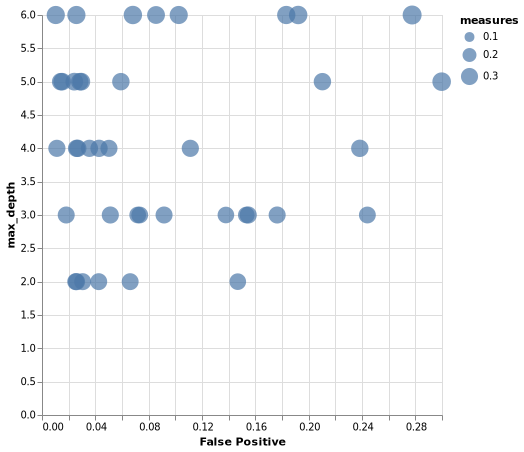

In [168]:
plt = @vlplot(
    data=hiper,
    :circle,
    x={:η, title="False Positive",type=:q},
    y={:max_depth, tiltle="True Positive", type=:q},
    size={:measures,
            },
    width=400,
    height=400
)